In [1]:
import concurrent.futures
import json
import os
import random
from glob import glob
from multiprocessing import Pool

import cv2
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sknw
import torch
from natsort import natsorted
from skimage.morphology import medial_axis, remove_small_objects
from torch_geometric.data import Data
from tqdm.notebook import tqdm

In [2]:
SIZE_CAP = 100

In [3]:
all_pngs = natsorted(glob("MAP_pngs_DEPTH_tvt/*/*/*.png"))

In [4]:
all_pngs

['MAP_pngs_DEPTH_tvt/test/benign/RP121_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP122_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP123_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP124_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP126_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP127_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP128_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP129_right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP131_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP135_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP137_right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP138_left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP139_Right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP140_Right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP142_Left_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP150_right_after_DL.png',
 'MAP_pngs_DEPTH_tvt/test/benign/RP150_right_clean_

In [5]:
benign_pngs = natsorted([x for x in all_pngs if "benign" in x])
malignant_pngs = natsorted([x for x in all_pngs if "malignant" in x])

In [6]:
pairs = list(zip(benign_pngs, malignant_pngs))
for pair in pairs:
    benign, malignant = pair
    assert benign.split("/")[-1].split("_")[0] == malignant.split("/")[-1].split("_")[0]

In [7]:
train_benign_pngs = benign_pngs[: SIZE_CAP // 2]
train_malignant_pngs = malignant_pngs[: SIZE_CAP // 2]
train_pairs = list(zip(benign_pngs, malignant_pngs))

test_benign_pngs = benign_pngs[SIZE_CAP // 2 :]
test_malignant_pngs = malignant_pngs[SIZE_CAP // 2 :]
test_pairs = list(zip(benign_pngs, malignant_pngs))

random.shuffle(train_pairs)
random.shuffle(test_pairs)

for pair in train_pairs:
    benign, malignant = pair
    assert benign.split("/")[-1].split("_")[0] == malignant.split("/")[-1].split("_")[0]
train_pngs = train_benign_pngs + train_malignant_pngs

for pair in test_pairs:
    benign, malignant = pair
    assert benign.split("/")[-1].split("_")[0] == malignant.split("/")[-1].split("_")[0]
test_pngs = test_benign_pngs + test_malignant_pngs

In [8]:
len(all_pngs), len(train_pngs), len(test_pngs)

(156, 100, 56)

In [9]:
train_graph_ids, train_png_paths = list(zip(*list(enumerate(train_pngs))))
train_png_paths = [x.split("/")[-1] for x in train_png_paths]
test_graph_ids, test_png_paths = list(zip(*list(enumerate(test_pngs))))
test_png_paths = [x.split("/")[-1] for x in test_png_paths]

In [10]:
train_graph_id_map = dict(zip(train_png_paths, train_graph_ids))
test_graph_id_map = dict(zip(test_png_paths, test_graph_ids))

In [11]:
train_graph_id_map

{'RP121_Left_after_DL.png': 0,
 'RP122_left_after_DL.png': 1,
 'RP123_Left_after_DL.png': 2,
 'RP124_Left_after_DL.png': 3,
 'RP126_Left_after_DL.png': 4,
 'RP127_Left_after_DL.png': 5,
 'RP128_left_after_DL.png': 6,
 'RP129_right_after_DL.png': 7,
 'RP131_left_after_DL.png': 8,
 'RP135_left_after_DL.png': 9,
 'RP137_right_after_DL.png': 10,
 'RP138_left_after_DL.png': 11,
 'RP139_Right_after_DL.png': 12,
 'RP140_Right_after_DL.png': 13,
 'RP142_Left_after_DL.png': 14,
 'RP150_right_after_DL.png': 15,
 'RP150_right_clean_after_DL.png': 16,
 'RP151_right_after_DL.png': 17,
 'RP151_right_clean_after_DL.png': 18,
 'RP152_right_after_DL.png': 19,
 'RP152_right_clean_after_DL.png': 20,
 'RP154_left_after_DL.png': 21,
 'RP154_left_clean_after_DL.png': 22,
 'WS025_right_after_DL.png': 23,
 'WS026_right_after_DL.png': 24,
 'RP059_paL_after_DL.png': 25,
 'RP060_left_after_DL.png': 26,
 'RP061_right_after_DL.png': 27,
 'RP062_left_after_DL.png': 28,
 'RP063_right_after_DL.png': 29,
 'RP065_right

In [12]:
def png_to_sknw(png_path: str) -> tuple[nx.Graph, np.ndarray]:
    """
    Convert a PNG image to a skeletonized graph.

    Args:
        png_path (str): The path to the PNG image.

    Returns:
        tuple[nx.Graph, np.ndarray]: A tuple containing the skeletonized graph and the cleaned skeleton image.
    """
    img = cv2.imread(png_path, 0)
    _, map_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skel, _ = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=10, min_size=10)

    skel_graph = sknw.build_sknw(skel_clean)

    return skel_graph, skel_clean

In [13]:
def visualize(png_path, sparsify_deg=None):
    skel_graph, skel_clean = png_to_sknw(png_path)

    if sparsify_deg:
        # Remove nodes with less than 3 edges
        nodes_to_remove = [
            node for node, degree in skel_graph.degree() if degree < sparsify_deg
        ]
        skel_graph.remove_nodes_from(nodes_to_remove)

    img = cv2.imread(png_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(122)
    plt.imshow(skel_clean, cmap="gray")
    # draw edges by pts
    for s, e in skel_graph.edges():
        ps = skel_graph[s][e]["pts"]
        plt.plot(ps[:, 1], ps[:, 0], "green")
    # draw node by o
    nodes = skel_graph.nodes()
    ps = np.array([nodes[i]["o"] for i in nodes])
    plt.plot(ps[:, 1], ps[:, 0], "r.")
    plt.title("Skeletonized Graph")
    plt.show()

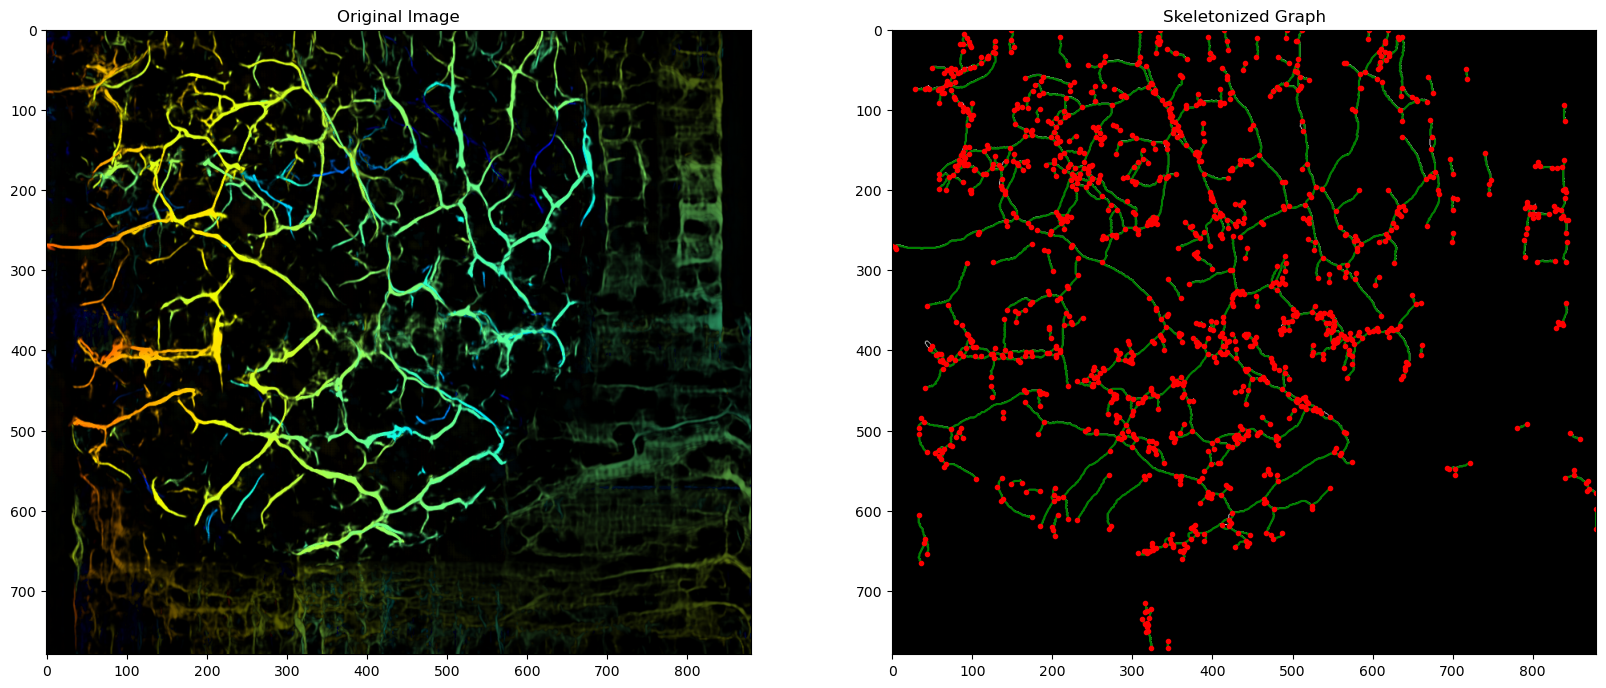

In [14]:
visualize(all_pngs[0])

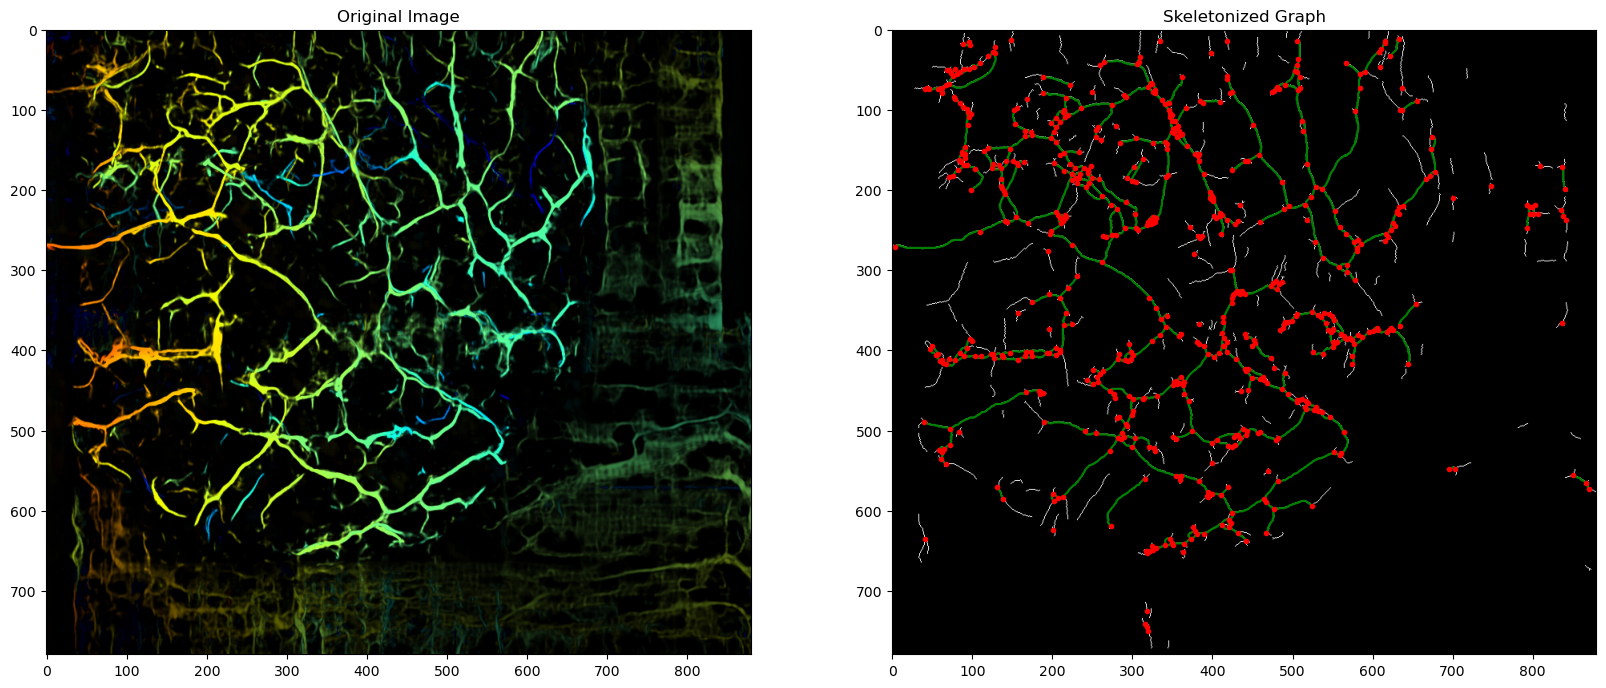

In [15]:
visualize(all_pngs[0], 2)

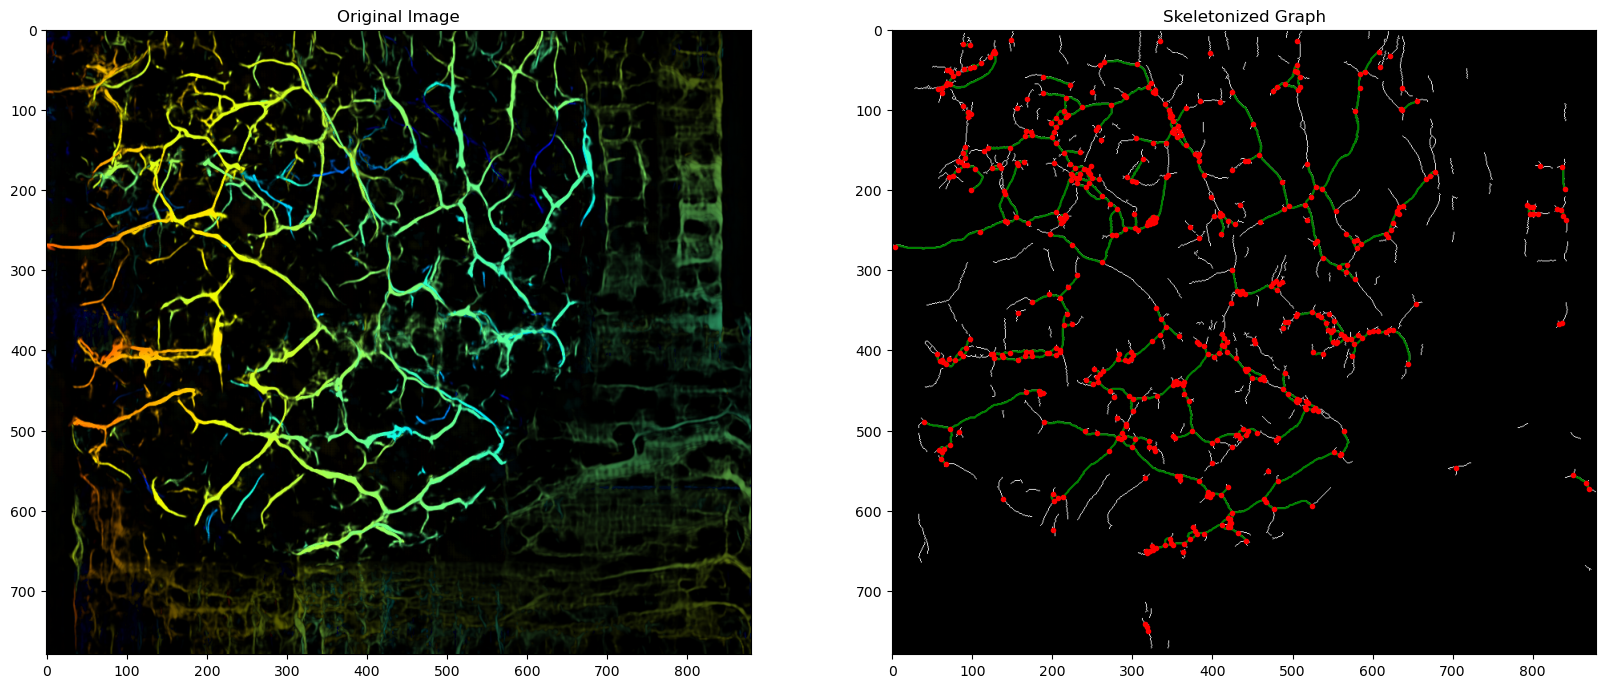

In [16]:
visualize(all_pngs[0], 3)

In [17]:
edge_count = 0
node_count = 0

train_edges = []
train_graph_ids = []
train_graph_labels = []
train_node_labels = []
tuples = []
for graph_id, png_path in tqdm(enumerate(train_pngs), total=len(train_pngs)):
    if "benign" in png_path:
        graph_label = 0
    else:
        graph_label = 1
    tuples.append(
        (graph_id, png_path.split("/")[-1], png_path.split("/")[-2], graph_label)
    )
    train_graph_labels.append(graph_label)

    img = cv2.imread(png_path, 0)
    _, map_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skel, distance = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=10, min_size=10)

    skel_graph = sknw.build_sknw(skel_clean)

    # Remove nodes with less than 3 edges
    nodes_to_remove = [node for node, degree in skel_graph.degree() if degree < 2]
    skel_graph.remove_nodes_from(nodes_to_remove)

    skel_graph = nx.convert_node_labels_to_integers(skel_graph, first_label=node_count)

    # DS_A
    graph_edges = skel_graph.edges()
    graph_edges = np.array(graph_edges)

    graph_edge_s = graph_edges.T[0].copy()
    graph_edge_e = graph_edges.T[1].copy()
    graph_edges_rev = np.array([graph_edge_e, graph_edge_s]).T

    graph_edges = np.concatenate([graph_edges, graph_edges_rev], axis=0)

    train_edges.append(graph_edges)

    graph_id_arr = np.repeat(graph_id, len(skel_graph.nodes()))
    train_graph_ids.append(graph_id_arr)

    node_label_arr = np.repeat(graph_label, len(skel_graph.nodes()))
    train_node_labels.append(node_label_arr)

    edge_count += len(skel_graph.edges())
    node_count += len(skel_graph.nodes())

if not os.path.exists(f"train/BREAST/BREAST/raw"):
    os.makedirs(f"train/BREAST/BREAST/raw")

train_edges = np.concatenate(train_edges, axis=0)
train_edges = pd.DataFrame(train_edges, columns=["source", "target"]) + 1
train_edges.to_csv(f"train/BREAST/BREAST/raw/BREAST_A.txt", index=False, header=False)

train_graph_ids = np.concatenate(train_graph_ids, axis=0)
train_graph_ids = pd.DataFrame(train_graph_ids, columns=["graph_id"]) + 1
train_graph_ids.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_graph_indicator.txt", index=False, header=False
)

train_graph_labels = pd.DataFrame(train_graph_labels, columns=["graph_label"])
train_graph_labels.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_graph_labels.txt", index=False, header=False
)

train_node_labels = np.concatenate(train_node_labels, axis=0)
train_node_labels = pd.DataFrame(train_node_labels, columns=["node_label"])
train_node_labels.to_csv(
    f"train/BREAST/BREAST/raw/BREAST_node_labels.txt", index=False, header=False
)

with open(f"train/BREAST/BREAST/raw/graph_id_map.json", "w") as f:
    json.dump(train_graph_id_map, f)

pd.DataFrame(
    tuples, columns=["graph_id", "png_path", "path_label", "graph_label"]
).to_csv("train/id_path_label.csv", index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
edge_count = 0
node_count = 0

test_edges = []
test_graph_ids = []
test_graph_labels = []
test_node_labels = []
tuples = []
for graph_id, png_path in tqdm(enumerate(test_pngs), total=len(test_pngs)):
    if "benign" in png_path:
        graph_label = 0
    else:
        graph_label = 1
    tuples.append(
        (graph_id, png_path.split("/")[-1], png_path.split("/")[-2], graph_label)
    )
    test_graph_labels.append(graph_label)

    img = cv2.imread(png_path, 0)
    _, map_thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    skel, distance = medial_axis(map_thresh, return_distance=True)
    skel_clean = remove_small_objects(skel, connectivity=10, min_size=10)

    skel_graph = sknw.build_sknw(skel_clean)

    # Remove nodes with less than 3 edges
    nodes_to_remove = [node for node, degree in skel_graph.degree() if degree < 2]
    skel_graph.remove_nodes_from(nodes_to_remove)

    skel_graph = nx.convert_node_labels_to_integers(skel_graph, first_label=node_count)

    # DS_A
    graph_edges = skel_graph.edges()
    graph_edges = np.array(graph_edges)

    graph_edge_s = graph_edges.T[0].copy()
    graph_edge_e = graph_edges.T[1].copy()
    graph_edges_rev = np.array([graph_edge_e, graph_edge_s]).T

    graph_edges = np.concatenate([graph_edges, graph_edges_rev], axis=0)

    test_edges.append(graph_edges)

    graph_id_arr = np.repeat(graph_id, len(skel_graph.nodes()))
    test_graph_ids.append(graph_id_arr)

    node_label_arr = np.repeat(graph_label, len(skel_graph.nodes()))
    test_node_labels.append(node_label_arr)

    edge_count += len(skel_graph.edges())
    node_count += len(skel_graph.nodes())

if not os.path.exists(f"test/BREAST/BREAST/raw"):
    os.makedirs(f"test/BREAST/BREAST/raw")

test_edges = np.concatenate(test_edges, axis=0)
test_edges = pd.DataFrame(test_edges, columns=["source", "target"]) + 1
test_edges.to_csv(f"test/BREAST/BREAST/raw/BREAST_A.txt", index=False, header=False)

test_graph_ids = np.concatenate(test_graph_ids, axis=0)
test_graph_ids = pd.DataFrame(test_graph_ids, columns=["graph_id"]) + 1
test_graph_ids.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_graph_indicator.txt", index=False, header=False
)

test_graph_labels = pd.DataFrame(test_graph_labels, columns=["graph_label"])
test_graph_labels.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_graph_labels.txt", index=False, header=False
)

test_node_labels = np.concatenate(test_node_labels, axis=0)
test_node_labels = pd.DataFrame(test_node_labels, columns=["node_label"])
test_node_labels.to_csv(
    f"test/BREAST/BREAST/raw/BREAST_node_labels.txt", index=False, header=False
)

with open(f"test/BREAST/BREAST/raw/graph_id_map.json", "w") as f:
    json.dump(test_graph_id_map, f)

pd.DataFrame(
    tuples, columns=["graph_id", "png_path", "path_label", "graph_label"]
).to_csv("test/id_path_label.csv", index=False)

  0%|          | 0/56 [00:00<?, ?it/s]

In [19]:
#  copy test_pngs to test/pngs

if not os.path.exists(f"test/pngs"):
    os.makedirs(f"test/pngs")

for png_path in test_pngs:
    os.system(f"cp {png_path} test/pngs")